## Models and Evaluation
---------------------------

### Imports

In [1]:
import pandas as pd    
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import re
import seaborn as sns
import codecs

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
# This is a library where you can generate classification data
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.datasets import make_classification 
from sklearn.ensemble import GradientBoostingClassifier, \
                            AdaBoostClassifier, \
                            VotingClassifier, \
                            RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')





In [2]:
submissions=pd.read_pickle('./datasets/submissions.pkl')

### Modeling

In [3]:
# create functions to return just the columns that you care about
get_text_data = FunctionTransformer(lambda x: x['all'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['word_count', 'sentiment']], validate = False)

In [4]:
X = submissions[['all', 'word_count','sentiment']]
y = submissions['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

### AdaBoost

In [5]:
pipe_ada = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('ada', AdaBoostClassifier())
])

params = {
            'features__text_features__cvec__stop_words' : [None, 'english'],
}

gs_ada = GridSearchCV(pipe_ada, params, cv=5)

gs_ada.fit(X_train, y_train)
gs_ada.score(X_train, y_train)

0.9034375

In [6]:
print(gs_ada.score(X_test, y_test))

0.90625


### Logistic Regression

In [7]:
pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression())
])

params = {
            'features__text_features__cvec__stop_words' : [None, 'english'],
            'logreg__penalty' : ['l1', 'l2']
}

gs = GridSearchCV(pipe, params, cv=5)

gs.fit(X_train, y_train)
gs.score(X_train, y_train)

0.985625

In [8]:
print(gs.score(X_test, y_test))

0.92875


In [9]:
gs.best_params_

{'features__text_features__cvec__stop_words': 'english',
 'logreg__penalty': 'l2'}

**Always Evaluate Your Models**

In [10]:
def nice_conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [11]:
# Here is our ADA Model
preds_ada = gs_ada.best_estimator_.predict(X_test)

nice_conmat(y_test, preds_ada, ['Star Trek', 'Star Wars'])

Accuracy Score: 0.90625


,Predicted Star Trek,Predicted Star Wars
Actual Star Trek,334,44
Actual Star Wars,31,391


In [12]:
def nice_conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [24]:
# Here is our LOG REG Model

nice_conmat(y_test, preds, ['Star Trek', 'Star Wars'])

Accuracy Score: 0.92875


,Predicted Star Trek,Predicted Star Wars
Actual Star Trek,331,47
Actual Star Wars,10,412


In [14]:
#coefficients

coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

In [15]:
# re-creating our features variable:

features = ['word_count', 'sentiment_score'] +\
gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

# no changes to our coefficient variable:
# I'm just bringing it down here
coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

In [16]:
coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients] #exponentiated coefficients
             })

coef_df

,features,coef,exp_coef
0,word_count,-1.827529,0.160810
1,sentiment_score,-0.070801,0.931647
2,00,0.086614,1.090476
3,000,-0.000356,0.999644
4,005,0.006667,1.006689
...,...,...,...
14177,zones,0.108754,1.114888
14178,zoom,0.218912,1.244722
14179,zooms,0.000010,1.000010
14180,zora,-0.000002,0.999998


In [17]:
coef_df.loc[coef_df['features'] == 'sentiment']

,features,coef,exp_coef
11108,sentiment,-3.369624e-07,1.0


In [18]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)

In [19]:
coef_df.tail(20)

,coef,exp_coef
features,,
janeway,-1.084077,0.338214
starship,-1.118433,0.326791
mirror,-1.122191,0.325566
worf,-1.153849,0.315420
lt,-1.156190,0.314683
riker,-1.167830,0.311041
federation,-1.243470,0.288382
dis,-1.245797,0.287711
captain,-1.372710,0.253419


In [20]:
coef_df['exp_coef'].tail(10).sort_values()

features
trek          0.015031
discovery     0.070841
tng           0.091246
enterprise    0.099854
ds9           0.117548
voyager       0.158052
word_count    0.160810
picard        0.162150
klingon       0.214631
borg          0.233782
Name: exp_coef, dtype: float64

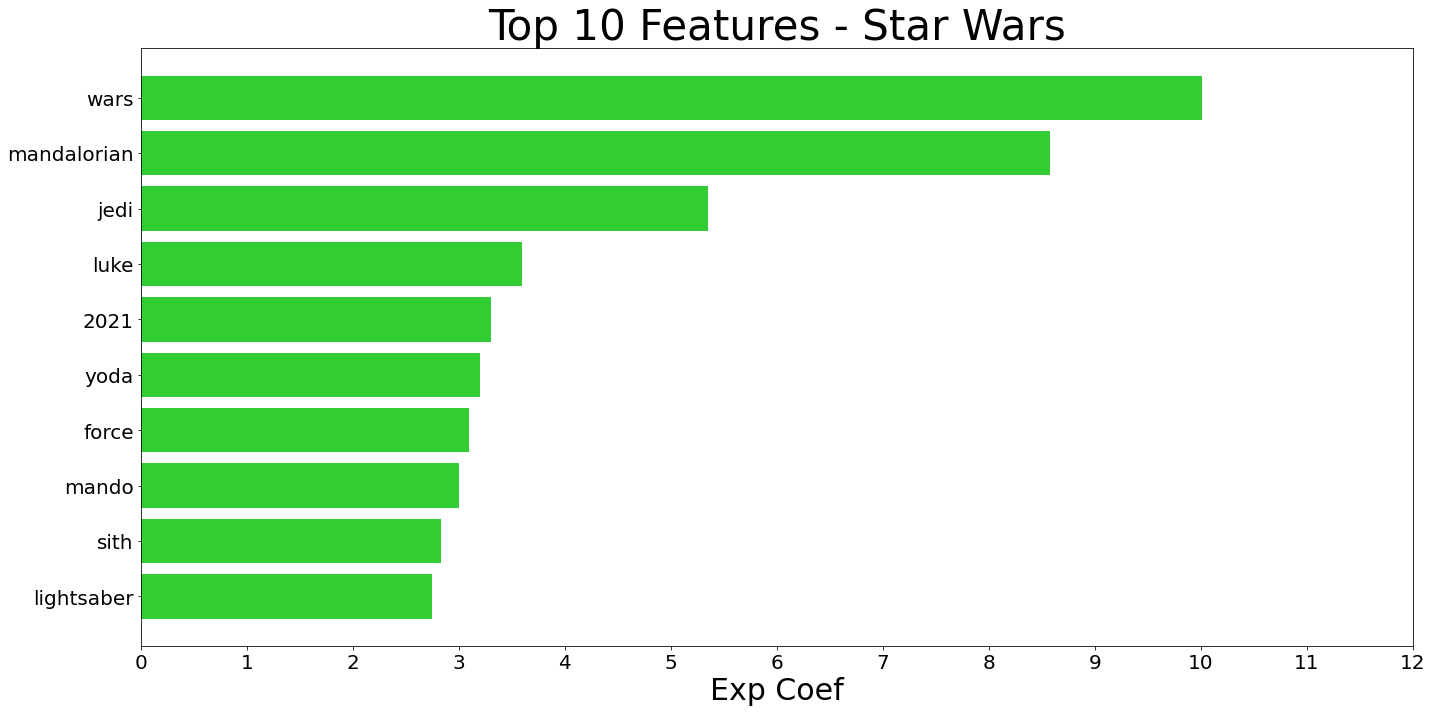

In [21]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'limegreen')
plt.yticks(fontsize=20)
plt.xticks(ticks= range(13), fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - Star Wars', fontsize=42)
plt.tight_layout()
plt.savefig('./images/top10starwars.png')

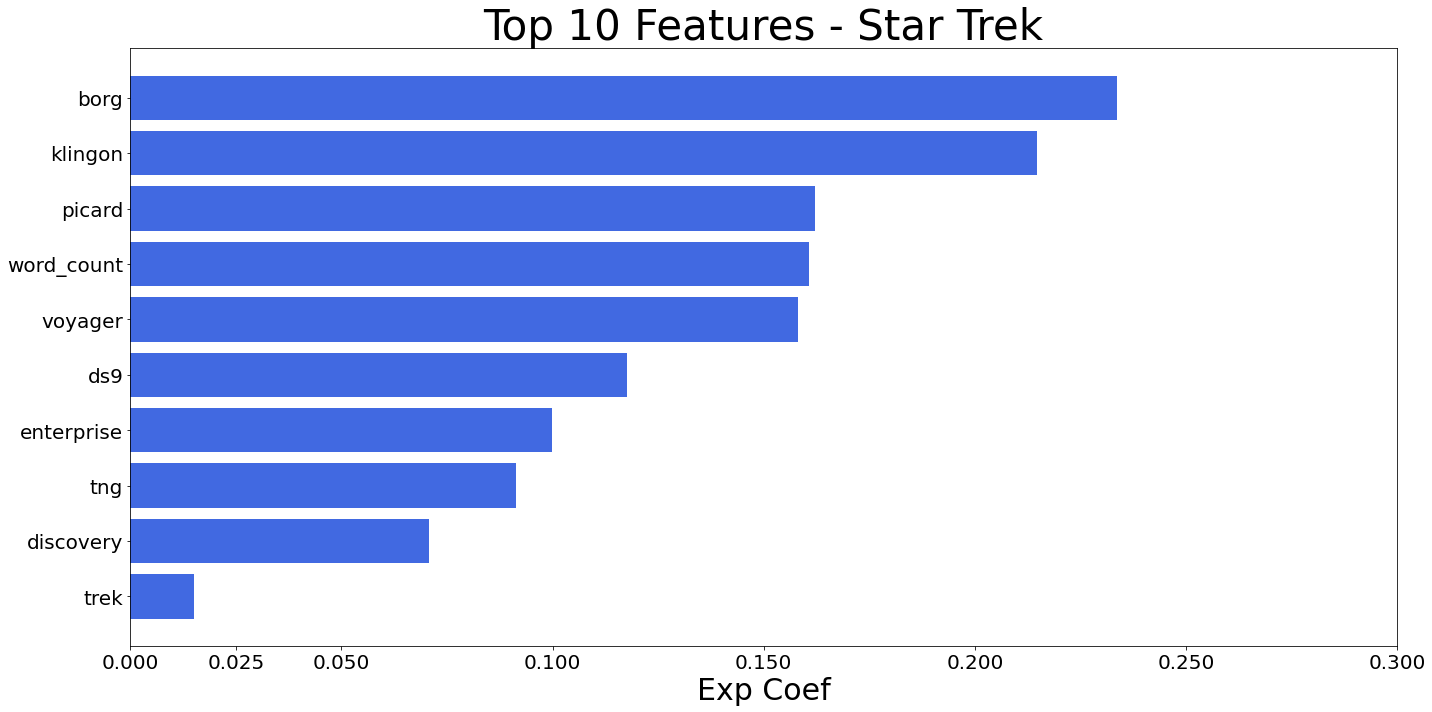

In [22]:
weights = coef_df['exp_coef'].tail(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'royalblue')
plt.yticks(fontsize=20)
plt.xticks(ticks= [0, 0.025,0.05,0.1, 0.15, 0.2, 0.25, 0.3] , fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - Star Trek', fontsize=42)
plt.tight_layout()
plt.savefig('./images/top10startrek.png')

In [23]:
coef_df

,coef,exp_coef
features,,
wars,2.303846,10.012614
mandalorian,2.148723,8.573902
jedi,1.676467,5.346632
luke,1.278738,3.592104
2021,1.194731,3.302670
...,...,...
ds9,-2.140904,0.117548
enterprise,-2.304047,0.099854
tng,-2.394193,0.091246
